# Florestas Randômicas: fraude de cartão de crédito

## Introdução

Florestas randômicas são uma técnica usada para classificação ou regressão, particularmente útil no contexto de mineração de dados e uma boa estrtégia quando existe um desbalanceamento entre as classes. Uma base de dados de fraude de cartão de crédito, que se encaixa nesse caso foi feita pelo MLG - Machine Learning Group e está disponível no Kaggle: 
[https://www.kaggle.com/mlg-ulb/creditcardfraud/](https://www.kaggle.com/mlg-ulb/creditcardfraud/) 

## Imports

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import time

from sklearn import datasets  
from sklearn.model_selection import train_test_split, RandomizedSearchCV, StratifiedKFold, KFold
from sklearn.ensemble import RandomForestClassifier 
from sklearn.tree import plot_tree
from sklearn.metrics import (
    classification_report, 
    accuracy_score, precision_score, recall_score, f1_score,
    roc_curve, auc, precision_recall_curve
)
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder

from custom_plot import *


## Fraud detection
### Read

In [2]:
X = pd.read_csv('creditcard.csv')

In [3]:
X.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [4]:
print(X.shape)

(284807, 31)


### Feature Engineering


In [5]:
y = X.Class
X.drop(['Class'], inplace=True, axis=1)

In [6]:
print(X.shape)
print(y.shape)

(284807, 30)
(284807,)


In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4)

### Analise de desbalanceamento das classes

In [8]:
counts = np.bincount(y_train)
print('Número de amostras com fraude nos dados de treinamento é {} ({:.2f}% do total)'.format(counts[1], 100 * float(counts[1]) / len(y_train)))

Número de amostras com fraude nos dados de treinamento é 282 (0.17% do total)


In [9]:
weight_for_0 = 1. / counts[0]
weight_for_1 = 1. / counts[1]

In [10]:
target_names=["1","0"]
feature_names=X_test.columns

In [11]:
#trinando a floresta randomica
rf_clf = RandomForestClassifier()
rf_clf.fit(X_train, y_train)

y_pred = rf_clf.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print('Accuracy:', accuracy)
print(classification_report(y_true=y_test, y_pred=y_pred, target_names=target_names))

Accuracy: 0.999438217041335
              precision    recall  f1-score   support

           1       1.00      1.00      1.00    113713
           0       0.93      0.75      0.83       210

    accuracy                           1.00    113923
   macro avg       0.96      0.88      0.92    113923
weighted avg       1.00      1.00      1.00    113923



## Shape of Tree in Forest

In [12]:
len(rf_clf.estimators_)

100

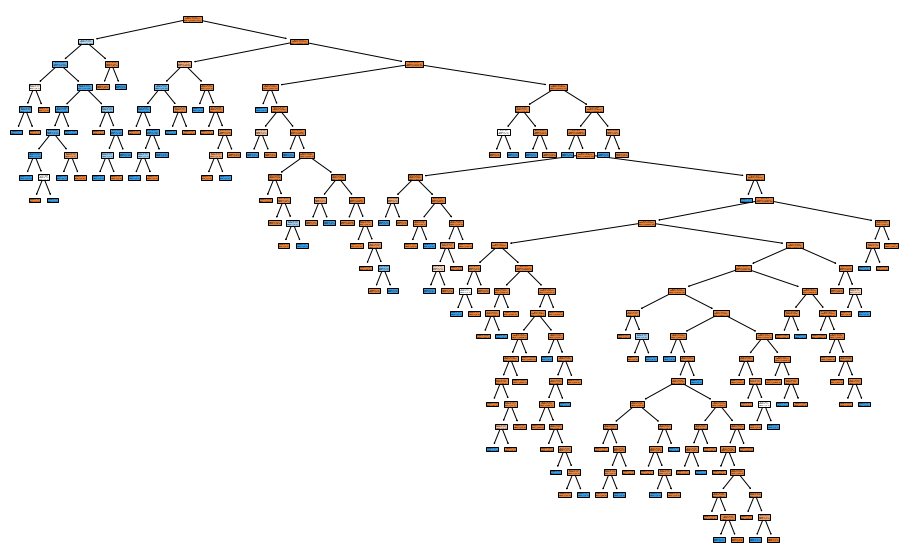

In [13]:
plt.figure(figsize=(16, 10))
plot_tree(rf_clf.estimators_[0], filled=True, feature_names=feature_names)
plt.show()

In [14]:
rf_clf.estimators_[0].get_depth()

23

In [15]:
# definindo os hyperparametros

# número de árvores na floresta
n_estimators = [int(x) for x in np.linspace(start = 1, stop = 50, num = 10)]
# Quantidadee de Features em cada split
max_features = ['auto', 'sqrt']
# Número máximo de níveis das árvores
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Quantidade mínima de amostras para dividir um nó
min_samples_split = [2, 5, 10]
# Quantidade mínima de amostras em cada nó
min_samples_leaf = [1, 2, 4]
# Método de seleção de dados de treinamento
bootstrap = [True, False]
# Criação de um grid aleatorizado
tuned_parameters = {'n_estimators': n_estimators,
                    'max_features': max_features,
                    'max_depth': max_depth,
                    'min_samples_split': min_samples_split,
                    'min_samples_leaf': min_samples_leaf,
                    'bootstrap': bootstrap}
print(tuned_parameters)

{'n_estimators': [1, 6, 11, 17, 22, 28, 33, 39, 44, 50], 'max_features': ['auto', 'sqrt'], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True, False]}


In [16]:
#ajustando o modelo com os hyperparametros definidos

scores = ['precision', 'recall']

score = scores[0]
print("# Ajuste dos hyper-parâmetros (%s)" % score)
print()

rf_clf_cv = RandomizedSearchCV(
    RandomForestClassifier(), tuned_parameters, cv=5, scoring='%s_macro' % score
)
rf_clf_cv.fit(X_train, y_train)

# Ajuste dos hyper-parâmetros (precision)



RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=RandomForestClassifier(bootstrap=True,
                                                    ccp_alpha=0.0,
                                                    class_weight=None,
                                                    criterion='gini',
                                                    max_depth=None,
                                                    max_features='auto',
                                                    max_leaf_nodes=None,
                                                    max_samples=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=2,
                                                    min_weight_fraction_leaf=0.0,
               

In [17]:
#melhores hyperparametros
print(rf_clf_cv.best_params_)

{'n_estimators': 22, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 50, 'bootstrap': True}


In [18]:
#obtendo dados para a curva roc

y_proba = rf_clf_cv.predict_proba(X_test)
y_test_ohe = OneHotEncoder(sparse=False).fit_transform(y_test.values.reshape(-1, 1))

# Calcular a curva ROC para cada classe
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(len(target_names)):
    fpr[i], tpr[i], _ = roc_curve(y_test_ohe[:, i], y_proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Calcular a "micro-average" da curva ROC e da AUC da ROC
fpr["micro"], tpr["micro"], _ = roc_curve(y_test_ohe.ravel(), y_proba.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

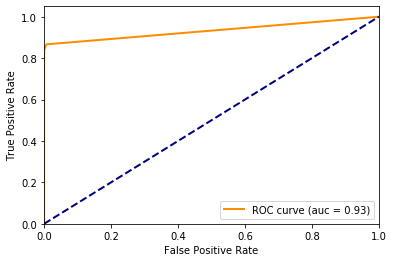

In [19]:
#plotando a curva roc
# mostra o desempenho geral do modelo, porém por se tratar de fraudes de cartao de crédito e dos dados estarem 
#desbalanceados, precisamos investigar melhor a performance para os casos de fraudes
plt.figure()
lw = 2
plt.plot(fpr[1], tpr[1], color='darkorange',
         lw=lw, label='ROC curve (auc = %0.2f)' % roc_auc[1])
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.show()

C:\Users\Gustavo\anaconda3\lib\site-packages\ipykernel_launcher.py:16: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  app.launch_new_instance()


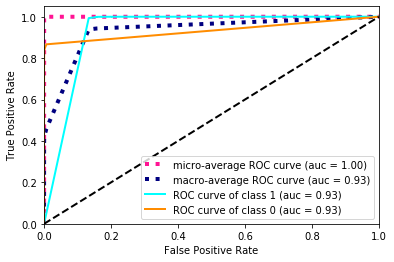

In [20]:
# apartir das curvas de precision-recall podemos observar o desempenho para cada classe separadamente, 
# para a classe 1, que são as fraudes, temos uma AUC de 93%, o que nos leva à uma média  macro de 93%
# pois a media macro leva em conta o resultado para as classes existentes independente
# da distribuicao dos dados, ja a media micro, avalia as metricas como um todo, independente da classe.

#https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html#sphx-glr-auto-examples-model-selection-plot-roc-py
from scipy import interp
from itertools import cycle

# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(len(target_names))]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(len(target_names)):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= len(target_names)

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure()
plt.plot(fpr["micro"], tpr["micro"],
         label=f'micro-average ROC curve (auc = {roc_auc["micro"]:0.2f})',
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label=f'macro-average ROC curve (auc = {roc_auc["macro"]:0.2f})',
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color, name in zip(range(len(target_names)), colors, target_names):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label=f'ROC curve of class {name} (auc = {roc_auc[i]:0.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.show()

In [21]:
#Validacao cruzada da floresta randomica testando diferentes profundidades da floresta
import warnings
warnings.filterwarnings("ignore")

N = 100
k = 5

skf = StratifiedKFold(n_splits=k, random_state=42)
thresholds = np.linspace(0, 1, N, endpoint=True)

metrics = {'accuracy':{}, 'precision':{}, 'recall':{}, 'f1':{}}

for train_index, test_index in skf.split(X, y):
    X_train, X_test = X .iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    rf_clf = RandomForestClassifier()
    rf_clf.fit(X_train, y_train)

    y_pred = rf_clf.predict_proba(X_test)
    
    
    for threshold in thresholds:
        metrics['accuracy'].setdefault(threshold,[]).append(accuracy_score(y_test==1, y_pred[:,1]>threshold))
        metrics['precision'].setdefault(threshold,[]).append(precision_score(y_test==1, y_pred[:,1]>threshold))
        metrics['recall'].setdefault(threshold,[]).append(recall_score(y_test==1, y_pred[:,1]>threshold))
        metrics['f1'].setdefault(threshold,[]).append(f1_score(y_test==1, y_pred[:,1]>threshold))

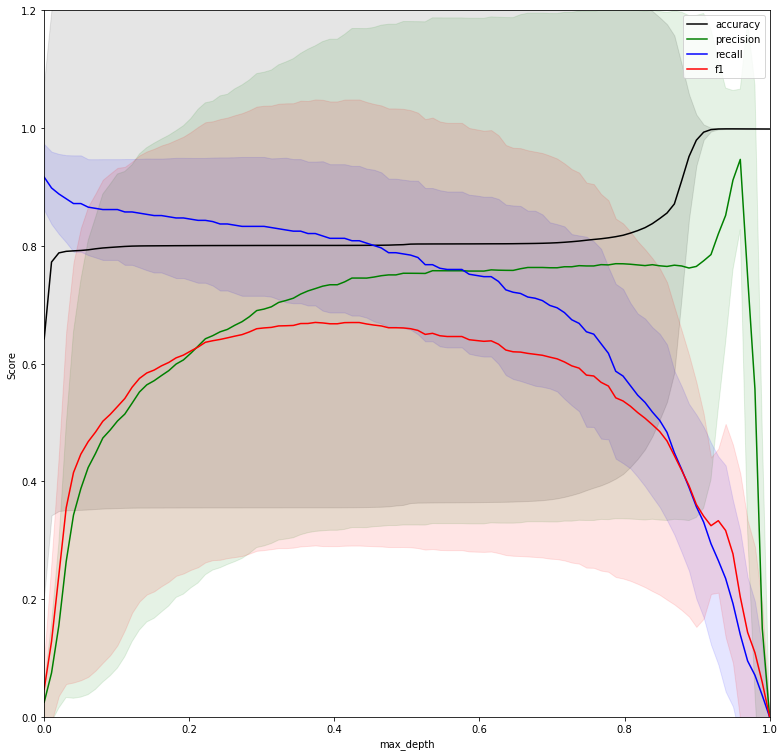

In [22]:
#como estamos avaliando dados de fraude de cartão, o objetivo principal é conseguir detectar o máximo de fraudes
# possível(recall) mas ao mesmo tempo não é interessante para o negócio muitos casos de falso positivos
#pois muitas transacoes seriam negadas sem ser fraude(precision).
#Observando o grafico abaixo, sob meu ponto de vista a melhor profundidade está entre 0.4 e 0.5, onde 
# o precision se estabiliza acima de 70% e o recall ainda está acima de 80%.
plt.figure(figsize=(13, 13))
plt.xlabel("max_depth")
plt.ylabel("Score")
ax = plt.gca()
ax.set_xlim(0.0, 1)
ax.set_ylim(0.0, 1.2)

for metric, color in zip(metrics.keys(), ['k', 'g', 'b', 'r']):
    metric_df = pd.DataFrame.from_dict(metrics[metric])
    ax.fill_between(thresholds, metric_df.mean() - metric_df.std(),
                    metric_df.mean() + metric_df.std(),
                    alpha=0.1, color=color)
    ax.plot(thresholds, metric_df.mean(), '-', color=color,
            alpha=1,
            label=metric)

plt.legend(loc="best")
plt.show()